# Performance evaluation analysis

This notebook contains the analyses performed for the "Analysis and Impact of Training Set Size in Cross-Subject Human Activity Recognition" paper, submitted to the 32nd International Conference on Artificial Neural Networks (ICANN 2023).

## Objectives

- Analyse the impact of the training set size in the performance of a model in terms of overall accuracy and activity-wise F1-score. Two types of data are used: from smartphone (sp) and from smartwatch (sw).
- Compare the performance metrics of the models depending on the type of data used (i.e., sp vs. sw).

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import pingouin as pg

import plotly.graph_objects as go 
import plotly.express as px
from plotly.subplots import make_subplots

from enum import Enum
from dataclasses import dataclass

## Functions

### Data Loading

In [2]:
REPORTS_PATH = os.path.join('02_MODEL-REPORTS', '{0}_models.csv')

RESULTS_PATH = '03_RESULTS'
EVOLUTION_RESULT = os.path.join('03_RESULTS', '{0}-ev.pdf')
TEST_RESULT = os.path.join('03_RESULTS', '{0}-tests.pdf')
TABLE_RESULT = os.path.join('03_RESULTS', '{0}-table.html')


def load_reports(file_path):
    return pd.read_csv(file_path)

### Filtering

In [3]:
class TargetFilter(Enum):
    MODEL = 'model'
    SEATED = 'SEATED'
    STANDING_UP = 'STANDING_UP'
    WALKING = 'WALKING'
    TURNING = 'TURNING'
    SITTING_DOWN = 'SITTING_DOWN'
    
    
    def __str__(self):
        return str(self.value)
    
    def __lt__(self, other):
        if self == other:
            return False
        
        return order.index(self) < order.index(other)

order = [TargetFilter.SEATED, TargetFilter.STANDING_UP, TargetFilter.WALKING, TargetFilter.TURNING, TargetFilter.SITTING_DOWN]
    
class ActivityMetric(Enum):
    PRECISION = 'precision'
    RECALL = 'recall'
    F1 = 'f1-score'
    SUPPORT = 'support'
    
    def __str__(self):
        return str(self.value)
    
    
class ModelMetric(Enum):
    ACCURACY = 'accuracy'
    TRAINING_TIME = 'training time'
    
    def __str__(self):
        return str(self.value)
    
    

@dataclass
class Filter:
    target: str
    metric: str
    
    def apply(self, df):
        return df[(df.target == str(self.target)) & (df.metric == str(self.metric))]

### Visualizations

In [4]:
def add_evolution_trace(fig, grouped_df, secondary=False, row=1, col=1, with_legend=True):
    means = grouped_df.mean(numeric_only=True)
    mins = grouped_df.min(numeric_only=True)
    maxs = grouped_df.max(numeric_only=True)
    stds = grouped_df.std(numeric_only=True)
    x = np.arange(1, len(means) + 1)
    
    if secondary: 
        line_color = 'purple'
        fill_color_range = 'rgba(106,13,173,0.4)'
        range_lines = dict(color='purple', dash='dash')
        fill_color_sd = 'rgba(255,255,0,0.4)'
        sd_lines = dict(color='yellow', dash='dot')
        legendgroup = 'secondary'
    else:
        line_color = 'red'
        fill_color_range = 'rgba(255,0,0,0.2)'
        range_lines = dict(color='red', dash='dash')
        fill_color_sd = 'rgba(0,0,255,0.2)'
        sd_lines = dict(color='purple', dash='dot')
        legendgroup = 'main'
        
    legendgrouptitle_text = f'{means.index[0][1].capitalize()} {means.index[0][2]}'
    
    fig = fig.add_trace(
        go.Scatter(x=x, y=mins['value'], 
                   mode="lines", line=range_lines, fill='tonexty', fillcolor='rgba(0,0,0,0)', showlegend=False),
        secondary_y=secondary, row=row, col=col)
    fig = fig.add_trace(
        go.Scatter(x=x, y=maxs['value'], name="range", legendgroup=legendgroup, legendgrouptitle_text=legendgrouptitle_text, showlegend=with_legend,
                   mode="lines", line=range_lines, fill='tonexty', fillcolor=fill_color_range), 
        secondary_y=secondary, row=row, col=col)
    fig = fig.add_trace(
        go.Scatter(x=x, y=np.maximum((means - stds)['value'], np.zeros(22)), 
                   mode="lines", line=sd_lines, fill='tonexty', fillcolor='rgba(0,0,0,0)', showlegend=False),
        secondary_y=secondary, row=row, col=col)
    fig = fig.add_trace(
        go.Scatter(x=x, y=(means + stds)['value'], name="sd", legendgroup=legendgroup, showlegend=with_legend, 
                   mode="lines", line=sd_lines, fill='tonexty', fillcolor=fill_color_sd),
        secondary_y=secondary, row=row, col=col)
    fig = fig.add_trace(
        go.Scatter(x=x, y=means['value'], name="avg", legendgroup=legendgroup, showlegend=with_legend,
                   mode="lines", line_color=line_color), 
        secondary_y=secondary, row=row, col=col)
    return fig
    

def plot_evolution(df, filters, fig_title, filters_secondary=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    #fig = go.Figure()

    df_fil = filters.apply(df)
    grouped_df = df_fil.groupby(['n', 'target', 'metric'])
    fig = add_evolution_trace(fig, grouped_df)
    fig.update_layout(
        #title=f'Leaving N Out: {fig_title}',
        height=400, width=1000,
        xaxis_title='Number of subjects in training',
        yaxis_title=f"{str(filters.target).capitalize()} {filters.metric}",
        xaxis_dtick=1,
        yaxis_dtick=0.2,
        yaxis_range=[-0.01,1]
        #showlegend=False
    )
    
    if filters_secondary:
        df_fil = filters_secondary.apply(df)
        grouped_df = df_fil.groupby(['n', 'target', 'metric'])
        fig = add_evolution_trace(fig, grouped_df, True)
        fig.update_yaxes(title_text=f"{str(filters_secondary.target).capitalize()} {filters_secondary.metric} (s)", secondary_y=True)
    
    return fig

In [5]:
def plot_comparison(dfs, filters, titles):
    fig = make_subplots(cols=len(dfs), rows=1, x_title='Number of subjects in training', y_title=f'{str(filters.metric).capitalize()}', subplot_titles=titles,
                       shared_yaxes=True, horizontal_spacing=0.05)
    
    for i, df in enumerate(dfs):
        df_fil = filters.apply(df)
        grouped_df = df_fil.groupby(['n', 'target', 'metric'])
        fig = add_evolution_trace(fig, grouped_df, col=i+1, with_legend=(i==0))
        fig.update_yaxes(dtick = 0.2, col=i+1)
        fig.update_xaxes(dtick = 1, col=i+1)
        
    fig.update_layout(
        height=300,
        width=1000,
        yaxis_range=[-0.01,1],
        showlegend=False
    )
    return fig

In [6]:
def plot_pairwise_comparision(data, filters, alternative='two-sided', stars=False, parametric=False):
    figure_index = np.arange(1,23)
    
    grouped_data = filters.apply(data).groupby("n")
    means = grouped_data.mean(numeric_only=True)["value"].values if parametric else grouped_data.median(numeric_only=True)["value"].values
    pairwise_means = means - means[:, None]
    np.fill_diagonal(pairwise_means, 101)
    pairwise_means = pd.DataFrame(np.triu(pairwise_means), index=figure_index, columns=figure_index)
    pairwise_means = pairwise_means.replace(101, "").applymap(mean_to_categorical).replace('', np.nan)
    
    pairwise_matrix = pairwise_n_comparision(data, filters, alternative=alternative, stars=False, parametric=parametric)
    pairwise_matrix = pairwise_matrix.where(np.triu(np.ones_like(pairwise_matrix, dtype=bool))).replace('-', np.nan).astype(float)

    color_value = pairwise_matrix * 0.4 + pairwise_means * 0.6 
    pairwise_matrix = pairwise_matrix.fillna('').applymap(p_value_formatter(True)) if stars else pairwise_matrix
        
    fig = go.Figure(
        go.Heatmap(
            z=color_value,
            x=figure_index,
            y=figure_index,
            hoverongaps = False,
            hovertemplate='B: %{x}<br>A: %{y}<br>p-value: %{text}<extra></extra>',
            text=pairwise_matrix,
            texttemplate="%{text}", 
            textfont_size=13,
            xgap = 2, ygap = 2,
            colorscale=[[0, 'rgb(153,0,0)'], [0.4, 'rgb(255,204,204)'], [0.6, 'rgb(0,153,0)'], [1, 'rgb(204,255,204)']],
            showscale=False,
        ),
        layout_plot_bgcolor = 'rgba(0,0,0,0)',
        layout_xaxis_gridcolor = 'darkgrey',
        layout_yaxis_gridcolor = 'darkgrey',
        layout_xaxis_gridwidth = 2,
        layout_yaxis_gridwidth = 2,
    )
    
    y_axis_config = { 'dtick': 1, 'title': 'Number of subjects (<i>n<sub>1</sub></i>)' }
    x_axis_config = { 'dtick': 1, 'title': 'Number of subjects (<i>n<sub>2</sub></i>)' }
    fig.update_layout(height=600, width=1200, xaxis=x_axis_config, yaxis=y_axis_config)
    return fig


def mean_to_categorical(x):
    if isinstance(x, str):
        return x
    return int(x < 0)   

### Statistical tests

In [7]:
pg.options['round.column.p-val'] = 3

#### Normality check

In [8]:
def check_normality(data):
    to_check = [(TargetFilter.MODEL, ModelMetric.ACCURACY), 
            (TargetFilter.SEATED, ActivityMetric.F1),
            (TargetFilter.STANDING_UP, ActivityMetric.F1),
            (TargetFilter.WALKING, ActivityMetric.F1),
            (TargetFilter.TURNING, ActivityMetric.F1),
            (TargetFilter.SITTING_DOWN, ActivityMetric.F1)]

    normality_table = np.full((22, 6), False)
    columns = []

    for i, (target_filter, metric) in enumerate(to_check):
        filtered = Filter(target_filter, metric).apply(data)
        columns.append(f'{target_filter} {metric}')
        for n in range(1, 23):
            filtered_n = filtered[filtered.n == n]
            normal = pg.normality(filtered_n['value']).loc['value']['normal']
            if normal:
                normality_table[n-1, i] = True

    return pd.DataFrame(normality_table, index=np.arange(1,23), columns=columns)

#### Pairwise comparisions

In [9]:
def pairwise_n_comparision(data, filters, alternative='two-sided', stars=False, parametric=False):
    data_filtered = filters.apply(data)
    
    if parametric:
        df = data_filtered[['n', 'i', 'value']].pivot(index='i', columns='n')['value']
        return df.ptests(stars=stars, alternative=alternative)
    
    non_parametric_pariwise = data_filtered.pairwise_tests(dv='value', between='n', parametric=False, alternative=alternative)

    mat = np.empty((22, 22))
    mat = mat.astype(str)

    formatter = p_value_formatter(stars)
    for i in range(1, 22):
        for j in range(i + 1, 23):
            row = non_parametric_pariwise[(non_parametric_pariwise.A == i) & (non_parametric_pariwise.B == j)]
            mat[i - 1,j - 1] = formatter(row['p-unc'].to_numpy()[0])
            mat[j - 1,i - 1] = row['U-val'].to_numpy()[0]
    np.fill_diagonal(mat, "-")
    index = np.arange(1, 23)
    return pd.DataFrame(mat, index=index, columns=index)


def p_value_formatter(stars, decimals=3):
    def as_value(val):
        return f'{val:.{decimals}}'
    def as_stars(val):
        if isinstance(val, str):
            try:
                val = float(val)
            except:
                return val
            
        if val < 0.001:
            return '***'
        elif val < 0.01:
            return '**'
        elif val < 0.05:
            return '*'
        else:
            return f'{val:.{decimals}}'
        
    return as_stars if stars else as_value

#### Groups comparision

In [10]:
def compare_datasources(datasource1, datasource2, filters, labels, alternative='two-sided', parametric=False):
    def test_builder():
        def mwu(g1, g2):
            res = pg.mwu(g1, g2, alternative=alternative).loc['MWU']
            return [g1.median().round(3), g2.median().round(3), res['U-val'], res['p-val']]
        
        def ttest(g1, g2):
            res = pg.ttest(g1, g2, alternative=alternative).loc['T-test']
            return [g1.mean().round(3), g2.mean().round(3), res['T'], res['p-val'], res['CI95%']]
        
        return ttest if parametric else mwu
        
    datasource1_fil = filters.apply(datasource1)
    datasource2_fil = filters.apply(datasource2)
    
    tester = test_builder()
    
    results = []
    for n in range(1, 23):
        datasource1_fil_n = datasource1_fil[datasource1_fil.n == n]['value']
        datasource2_fil_n = datasource2_fil[datasource2_fil.n == n]['value']
        
        test_results = tester(datasource1_fil_n, datasource2_fil_n)
        results.append([n] + test_results)
 
    
    test_cols = [f'mean({labels[0]})', f'mean({labels[1]})', 'T', 'p-val', 'CI95%'] if parametric else [f'median({labels[0]})', f'median({labels[1]})', 'U-val', 'p-val']
    return pd.DataFrame(results, columns=['n'] + test_cols)


def compare_activities(datasource1, datasource2, activity_metric, labels, alternative='two-sided', parametric=False):
    activity_comparisions = []
    activity_filters = [TargetFilter.SEATED, TargetFilter.STANDING_UP, TargetFilter.WALKING, TargetFilter.TURNING, TargetFilter.SITTING_DOWN]
    for activity in activity_filters:
        activity_comparision = compare_datasources(datasource1, datasource2, Filter(activity, activity_metric), labels, alternative, parametric)
        activity_comparision['activity'] = activity
        activity_comparisions.append(activity_comparision)
        
    df = pd.concat(activity_comparisions, ignore_index=True)
    columns = df.columns.to_list()
    columns.remove('n')
    columns.remove('activity')
    df = df.sort_values(['n', 'activity']).reset_index(drop=True)[['n', 'activity'] + columns]
    df = df.pivot(index='n', columns='activity', values=['median(sw)', 'median(sp)', 'p-val']).stack(0).unstack()
    return df

## Analysis

### Load the performance metrics

The performance metrics from the incremental LOSO training are loaded from `02_MODEL-REPORTS`.

In [11]:
reports_sp = load_reports(REPORTS_PATH.format('sp'))
reports_sw = load_reports(REPORTS_PATH.format('sw'))

### Performance metrics evolution

#### Overall evolution

First, we plot the accuracy of the models (average, sd and range) for each value of _n_ and each data source (i.e., smartphone and smartwatch). The training time is also included in the plots.

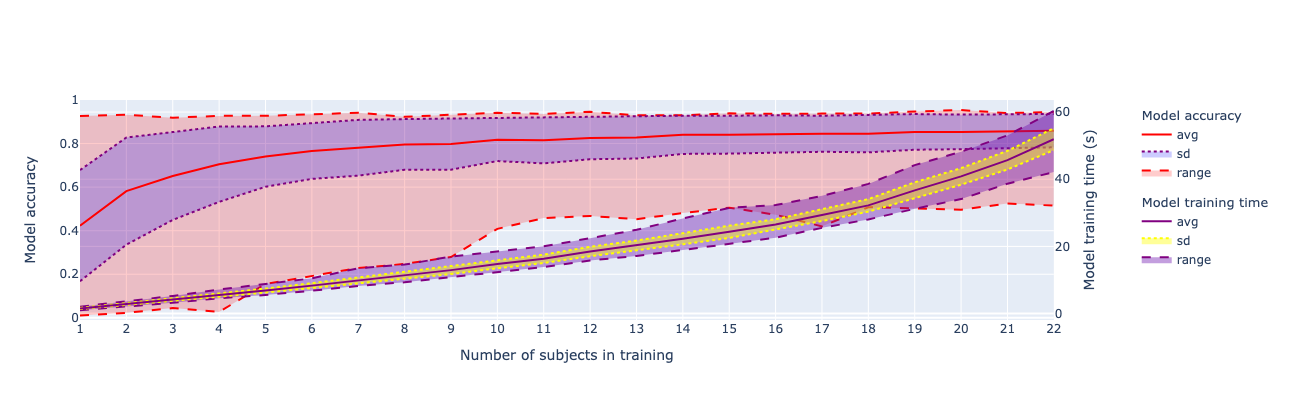

In [12]:
sp_ev = plot_evolution(reports_sp, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), 'sp', Filter(TargetFilter.MODEL, ModelMetric.TRAINING_TIME))
sp_ev

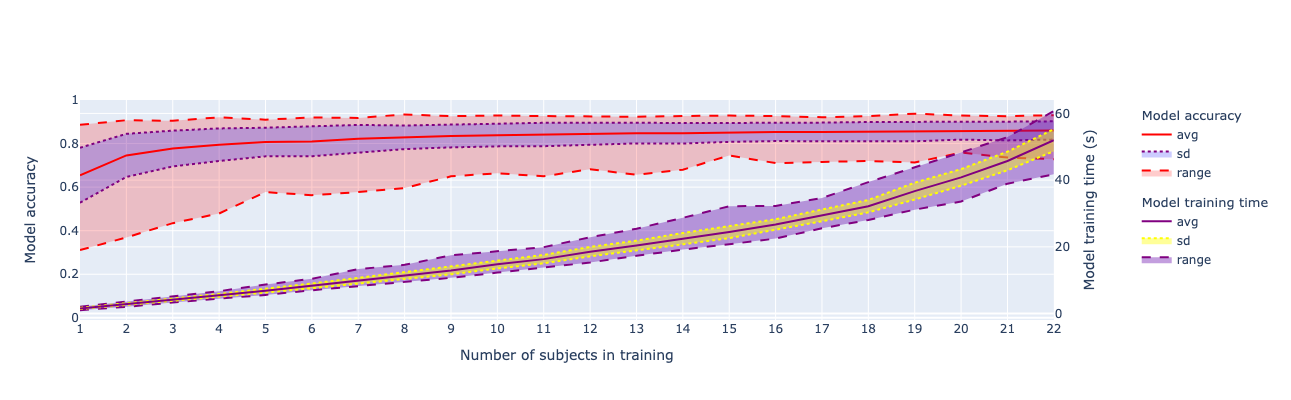

In [13]:
sw_ev = plot_evolution(reports_sw, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), 'sw', Filter(TargetFilter.MODEL, ModelMetric.TRAINING_TIME))
sw_ev

**These two plots correspond with the Figure 2 (a and b) of the paper.**

We can observe that:
- The _sp_ models show an abrupt evolution for low amount of data (_n_ < 7).
- The _sw_ models have a smoother evolution than the _sp_ ones.
- With higher amounts of data, the accuracy on both types of models seems to stabilize.

Statistical tests will be needed to determine if the improvement is statistically significant.

##### Store results

These figures are stored in `03_RESULTS/01_{sp|sw}-ev.pdf`.

In [15]:
sw_ev.write_image(EVOLUTION_RESULT.format('01_sw'))
sp_ev.write_image(EVOLUTION_RESULT.format('01_sp'))

#### Activities evolution

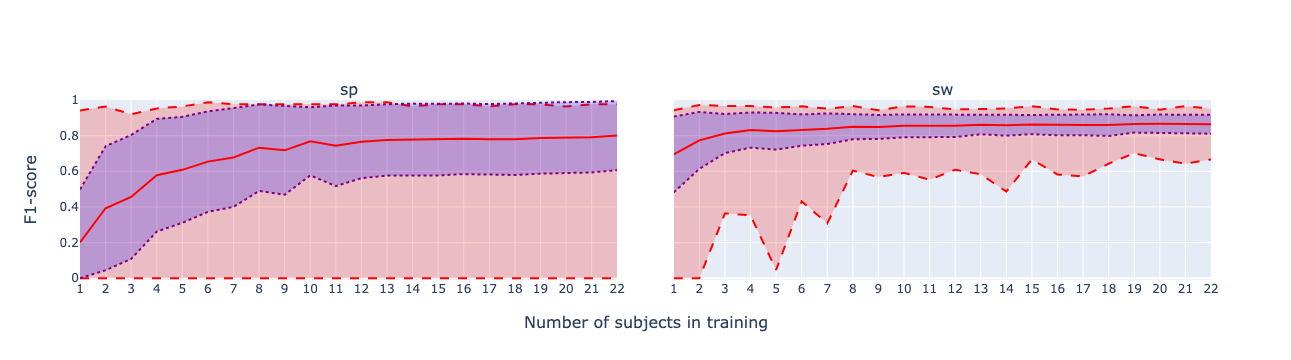

In [16]:
seated_ev = plot_comparison([reports_sp, reports_sw], Filter(TargetFilter.SEATED, ActivityMetric.F1), ['sp', 'sw'])
seated_ev

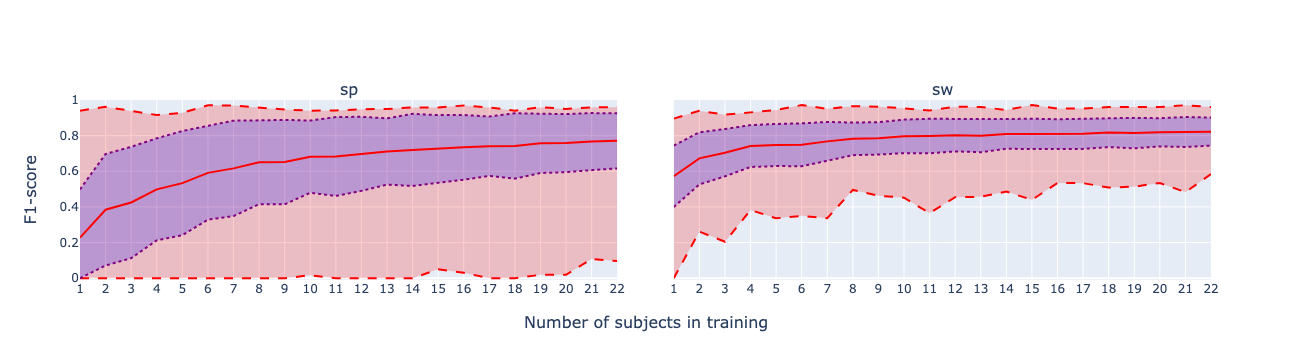

In [17]:
standing_up_ev = plot_comparison([reports_sp, reports_sw], Filter(TargetFilter.STANDING_UP, ActivityMetric.F1), ['sp', 'sw'])
standing_up_ev

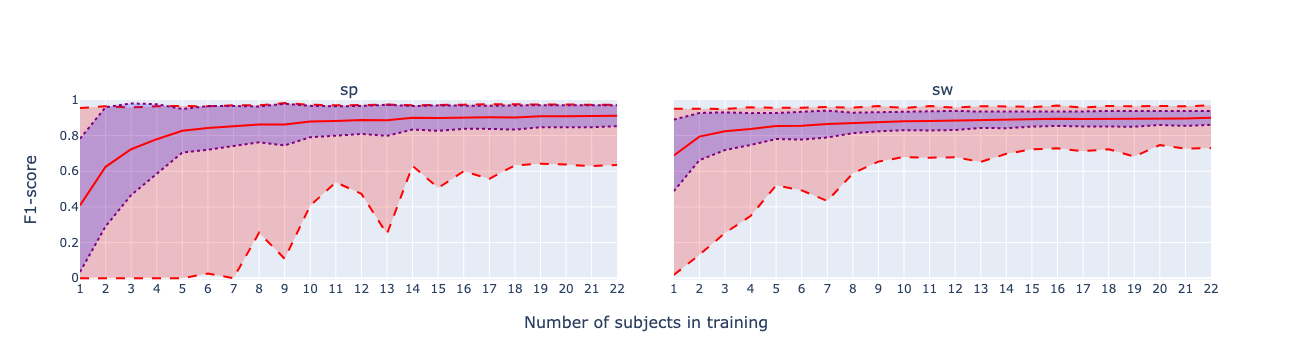

In [18]:
walking_ev = plot_comparison([reports_sp, reports_sw], Filter(TargetFilter.WALKING, ActivityMetric.F1), ['sp', 'sw'])
walking_ev

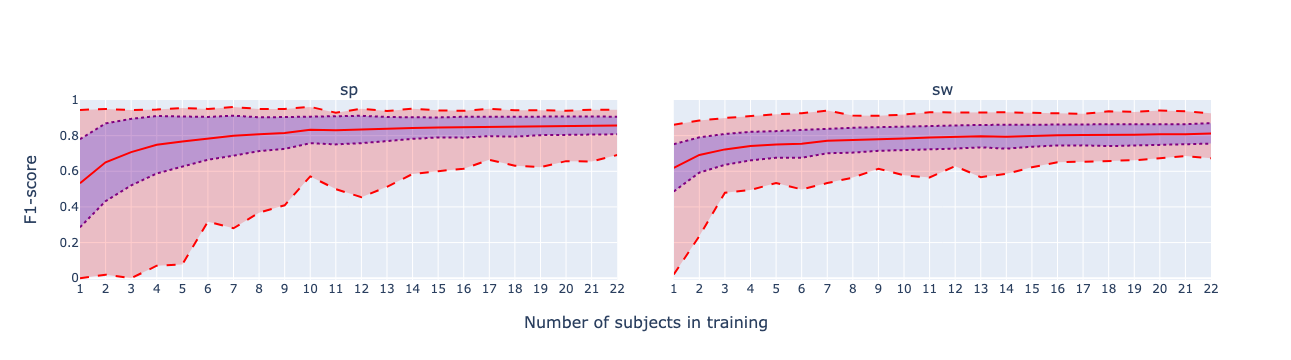

In [19]:
turning_ev = plot_comparison([reports_sp, reports_sw], Filter(TargetFilter.TURNING, ActivityMetric.F1), ['sp', 'sw'])
turning_ev

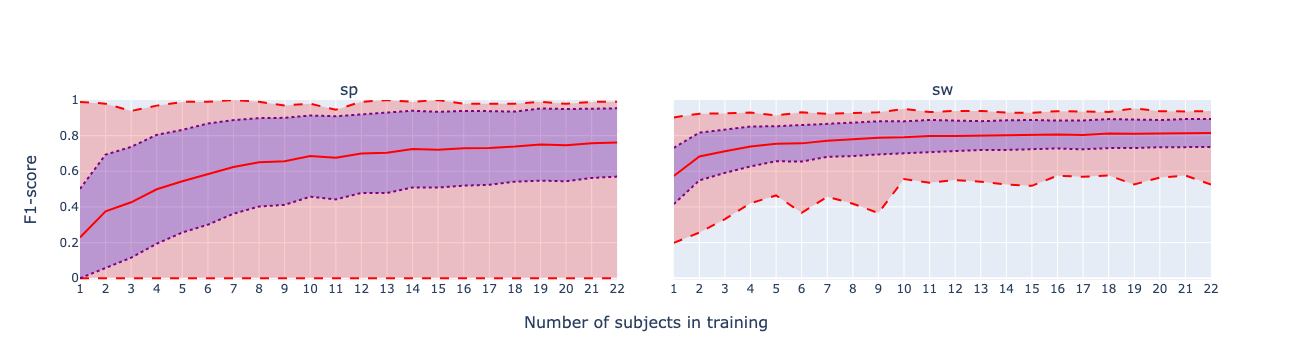

In [20]:
sitting_down_ev = plot_comparison([reports_sp, reports_sw], Filter(TargetFilter.SITTING_DOWN, ActivityMetric.F1), ['sp', 'sw'])
sitting_down_ev

**These five plots correspond with the Figure 4 (a-e) of the paper.**

We can observe that:
- The evolution trends are similar as before: abrupt evolution for _sp_ models and smooth evolution for _sw_ models.
- Poor performance of _sitting_, _standing up_ and _sitting down_ activities in the _sp_ models.
- _sp_ models seem to perform better than the _sw_ ones for the _walking_ and _turning_ activities.

##### Store results

These figures are stored in `03_RESULTS/02_{activity}-ev.pdf`.

In [21]:
seated_ev.write_image(EVOLUTION_RESULT.format('02_seated'))
standing_up_ev.write_image(EVOLUTION_RESULT.format('02_standing_up'))
walking_ev.write_image(EVOLUTION_RESULT.format('02_walking'))
turning_ev.write_image(EVOLUTION_RESULT.format('02_turning'))
sitting_down_ev.write_image(EVOLUTION_RESULT.format('02_sitting_down'))

##### What is causing those F1-score = 0?

s06    0.972603
s10    0.013699
s19    0.013699
Name: test_subject, dtype: float64


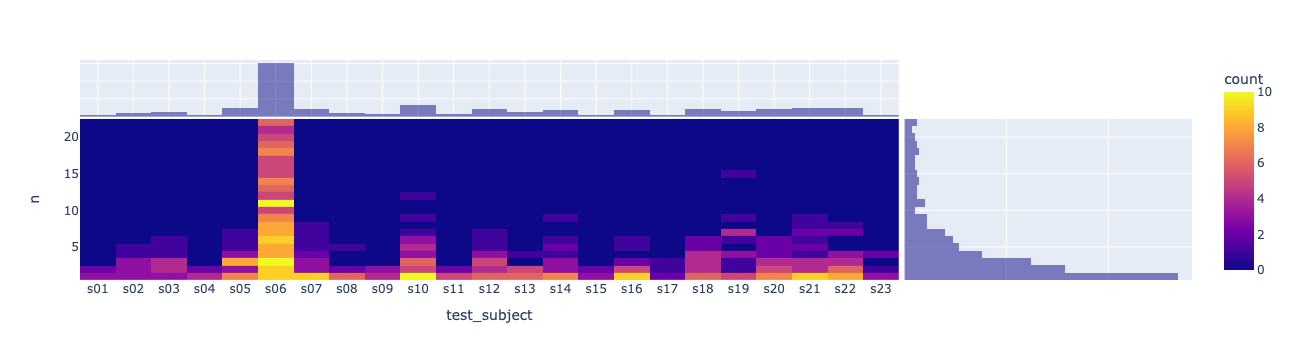

In [22]:
seated_fails = Filter(TargetFilter.SEATED, ActivityMetric.F1).apply(reports_sp)
print(seated_fails[(seated_fails.value == 0) & (seated_fails.n > 10)]['test_subject'].value_counts(normalize=True))
px.density_heatmap(seated_fails[seated_fails.value == 0], y="n", x="test_subject", nbinsy=22,marginal_x="histogram", marginal_y="histogram")

s06    0.916667
s02    0.083333
Name: test_subject, dtype: float64


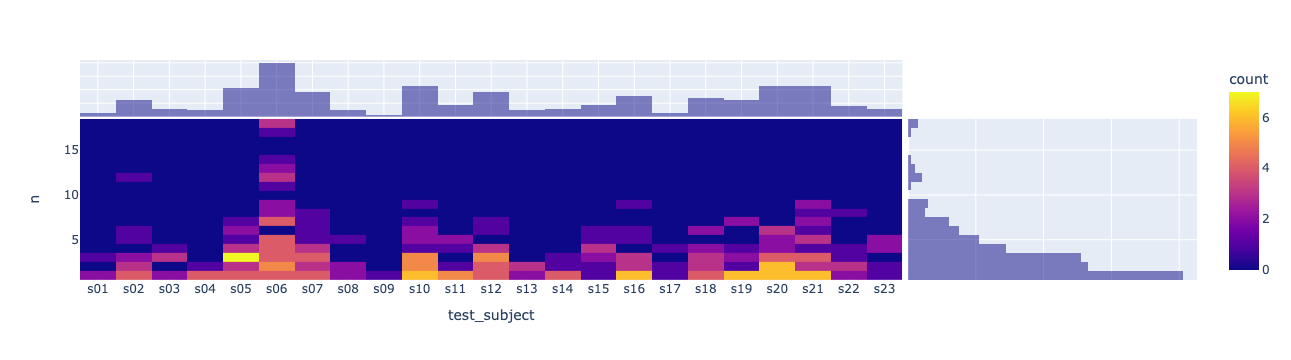

In [23]:
standing_up_fails = Filter(TargetFilter.STANDING_UP, ActivityMetric.F1).apply(reports_sp)
print(standing_up_fails[(standing_up_fails.value == 0) & (standing_up_fails.n > 10)]['test_subject'].value_counts(normalize=True))
px.density_heatmap(standing_up_fails[standing_up_fails.value == 0], y="n", x="test_subject", nbinsy=22,marginal_x="histogram", marginal_y="histogram")

s06    0.956522
s18    0.021739
s21    0.021739
Name: test_subject, dtype: float64


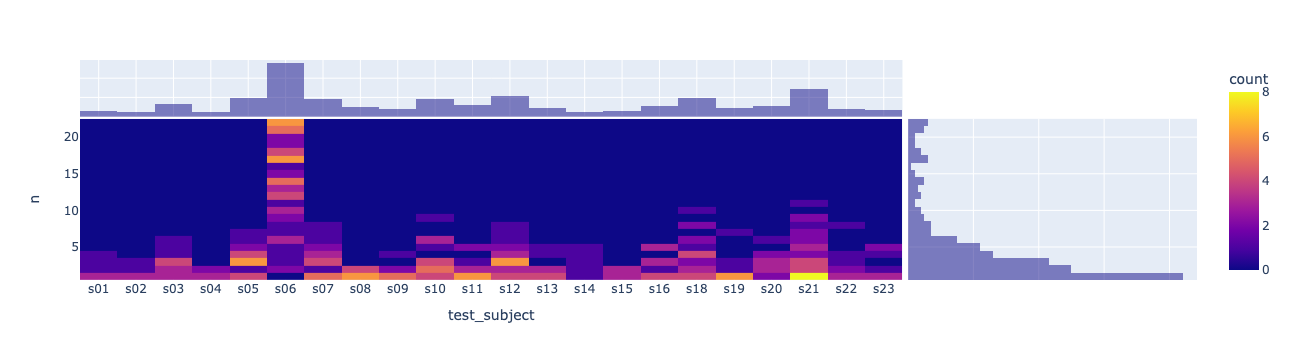

In [24]:
sitting_down_fails = Filter(TargetFilter.SITTING_DOWN, ActivityMetric.F1).apply(reports_sp)
print(sitting_down_fails[(sitting_down_fails.value == 0) & (sitting_down_fails.n > 9)]['test_subject'].value_counts(normalize=True))
px.density_heatmap(sitting_down_fails[sitting_down_fails.value == 0], y="n", x="test_subject", nbinsy=22,marginal_x="histogram", marginal_y="histogram")

From these histograms above, we can see that the subject **s06** caused the higher amount of F1-score = 0. When the _n_ &geq; 10, **s06** caused the 97, 91 and 95% of the F1-scores = 0 in the _seated_, _standing_up_ and _sitting_down_ activities.

#### Statistical tests

To determine if the improvement of the models while adding more training data is significant, statistical test have to be executed. 

First, we have to test the normality of the data in order to know the type of the test to use to compare the groups:
- Normal data &rarr; parametric tests: **Student's t-test**
- Non-normal data &rarr; non-parametric tests: **Mann-Whitney U test**

In [25]:
check_normality(reports_sp)

model accuracy  SEATED f1-score  STANDING_UP f1-score  WALKING f1-score  \
1            False            False                 False             False   
2            False            False                 False             False   
3            False            False                 False             False   
4            False            False                 False             False   
5            False            False                 False             False   
6            False            False                 False             False   
7            False            False                 False             False   
8            False            False                 False             False   
9            False            False                 False             False   
10           False            False                 False             False   
11           False            False                 False             False   
12           False            False                 False             False   
13           False            False                 False             False   
14           False            False                 False             False   
15           False            False                 False             False   
16           False            False                 False             False   
17           False            False                 False             False   
18           False            False                 False             False   
19           False            False                 False             False   
20           False            False                 False             False   
21           False            False                 False             False   
22           False            False                 False             False   

    TURNING f1-score  SITTING_DOWN f1-score  
1              False                  False  
2              False                  False  
3              False                  False  
4              False                  False  
5              False                  False  
6              False                  False  
7              False                  False  
8              False                  False  
9              False                  False  
10             False                  False  
11             False                  False  
12             False                  False  
13             False                  False  
14             False                  False  
15             False                  False  
16             False                  False  
17             False                  False  
18             False                  False  
19             False                  False  
20             False                  False  
21             False                  False  
22             False                  False

In [26]:
check_normality(reports_sw)

model accuracy  SEATED f1-score  STANDING_UP f1-score  WALKING f1-score  \
1            False            False                 False             False   
2            False            False                 False             False   
3            False            False                 False             False   
4            False            False                 False             False   
5            False            False                 False             False   
6            False            False                 False             False   
7            False            False                 False             False   
8            False            False                 False             False   
9            False            False                 False             False   
10           False            False                 False             False   
11           False            False                 False             False   
12           False            False                 False             False   
13           False            False                 False             False   
14           False            False                 False             False   
15           False            False                 False             False   
16           False            False                 False             False   
17           False            False                 False             False   
18           False            False                 False             False   
19           False            False                 False             False   
20           False            False                 False             False   
21           False            False                 False             False   
22           False            False                 False             False   

    TURNING f1-score  SITTING_DOWN f1-score  
1              False                  False  
2              False                  False  
3              False                  False  
4              False                  False  
5               True                  False  
6              False                  False  
7               True                  False  
8              False                  False  
9              False                  False  
10             False                  False  
11             False                  False  
12             False                  False  
13             False                  False  
14             False                  False  
15              True                  False  
16             False                  False  
17             False                  False  
18             False                  False  
19             False                  False  
20             False                  False  
21             False                  False  
22             False                  False

Overall, the data is not normal, so non-parametric tests are going to be executed. Therefore, to compare the groups the **Mann-Whitney U-test** is going to be used.

##### Table format (including statistic and p-value)

In [27]:
sp_pairwise_table = pairwise_n_comparision(reports_sp, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), stars=False, parametric=False, alternative='two-sided')
sp_pairwise_table

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



1        2        3        4        5        6        7        8   \
1         -      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2   17234.0        -    0.007      0.0      0.0      0.0      0.0      0.0   
3   13183.5  22577.5        -    0.003      0.0      0.0      0.0      0.0   
4   10168.0  18717.0  22178.0        -    0.059      0.0      0.0      0.0   
5    8248.0  16415.0  19605.5  23762.0        -    0.049      0.0      0.0   
6    6850.0  14129.5  16993.5  20921.0  23642.5        -     0.08    0.003   
7    6098.0  12597.0  15145.5  18779.0  21484.5  23954.5        -    0.258   
8    5314.0  11128.0  13429.0  16907.0  19764.0  22180.0  24837.0        -   
9    5179.5  11075.0  13326.5  16827.0  19533.0  21984.0  24586.0  26268.0   
10   4123.0   9220.5  11226.5  14318.5  17062.5  19285.0  21933.5  23433.0   
11   4384.5   9479.0  11454.0  14409.5  17124.0  19246.0  21664.0  23047.0   
12   3865.5   8532.5  10348.0  13159.5  15818.0  17799.0  20314.0  21603.5   
13   3697.0   8131.5   9936.5  12650.0  15373.0  17353.0  19910.0  21184.5   
14   3117.5   7077.0   8621.5  11015.0  13754.5  15544.0  18006.5  19124.0   
15   3151.5   7062.5   8644.5  11203.0  13758.5  15642.0  18223.5  19326.5   
16   2940.0   6669.0   8102.0  10551.5  13122.0  14803.5  17263.5  18351.0   
17   2814.5   6531.0   7971.0  10305.5  12973.5  14630.5  17177.5  18407.0   
18   2945.0   6600.0   8106.5  10519.0  13061.5  14820.5  17281.0  18378.0   
19   2515.0   5774.0   7023.0   9063.0  11617.0  13039.5  15436.5  16352.0   
20   2463.5   5745.0   7005.5   9069.0  11633.5  13111.0  15482.5  16400.0   
21   2450.5   5618.0   6852.5   8907.0  11324.0  12787.0  15153.0  16006.0   
22   2267.0   5282.0   6420.0   8363.5  10814.0  12123.5  14463.0  15281.0   

         9        10  ...       13       14       15       16       17  \
1       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
2       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
4       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
5       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
6     0.002      0.0  ...      0.0      0.0      0.0      0.0      0.0   
7     0.191    0.002  ...      0.0      0.0      0.0      0.0      0.0   
8     0.899    0.034  ...      0.0      0.0      0.0      0.0      0.0   
9         -     0.05  ...      0.0      0.0      0.0      0.0      0.0   
10  23658.0        -  ...    0.119    0.002    0.004      0.0      0.0   
11  23300.5  25985.5  ...    0.239    0.009    0.011    0.001    0.003   
12  21889.0  24531.5  ...    0.886    0.103    0.128    0.027    0.042   
13  21434.0  24225.0  ...        -    0.109    0.147    0.033    0.045   
14  19408.5  22001.5  ...  24164.5        -    0.916    0.594    0.699   
15  19642.0  22287.5  ...  24383.0  26600.0        -    0.509    0.598   
16  18599.0  21336.0  ...  23411.0  25690.5  25508.0        -    0.832   
17  18660.0  21265.5  ...  23592.5  25897.5  25698.5  26753.0        -   
18  18614.5  21359.5  ...  23344.0  25571.5  25316.5  26252.5  26030.5   
19  16651.0  19173.5  ...  21235.0  23569.5  23448.0  24363.5  23942.0   
20  16742.5  19254.5  ...  21348.5  23691.0  23551.5  24477.5  24099.0   
21  16235.0  18765.5  ...  20697.0  22946.5  22959.0  23718.5  23259.0   
22  15477.0  18054.0  ...  20005.0  22207.0  22186.0  23049.5  22499.0   

         18       19       20       21     22  
1       0.0      0.0      0.0      0.0    0.0  
2       0.0      0.0      0.0      0.0    0.0  
3       0.0      0.0      0.0      0.0    0.0  
4       0.0      0.0      0.0      0.0    0.0  
5       0.0      0.0      0.0      0.0    0.0  
6       0.0      0.0      0.0      0.0    0.0  
7       0.0      0.0      0.0      0.0    0.0  
8       0.0      0.0      0.0      0.0    0.0  
9       0.0      0.0      0.0      0.0    0.0  
10      0.0      0.0      0.0  

In [28]:
sw_pairwise_table = pairwise_n_comparision(reports_sw, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), stars=False, parametric=False, alternative='two-sided')
sw_pairwise_table

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



1        2        3        4        5        6        7        8   \
1         -      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2   14447.0        -    0.001      0.0      0.0      0.0      0.0      0.0   
3   10294.0  21576.5        -    0.012      0.0      0.0      0.0      0.0   
4    8311.0  18212.0  22857.5        -    0.147    0.035      0.0      0.0   
5    6672.0  16015.5  20596.0  24383.0        -     0.49    0.005      0.0   
6    6467.0  15274.5  19711.0  23451.5  25464.5        -    0.036    0.003   
7    5034.0  12676.0  16920.0  20606.0  22467.5  23457.5        -    0.438   
8    4172.5  11383.0  15738.0  19147.5  21014.0  22172.0  25344.5        -   
9    3705.5  10399.0  14381.0  17794.5  19588.5  20512.5  23499.5  24673.5   
10   3392.5   9624.0  13503.0  16767.5  18544.0  19521.0  22379.0  23593.0   
11   3299.0   9077.0  12790.0  15822.5  17518.5  18440.0  21202.5  22364.5   
12   3015.5   8553.0  12151.5  15081.0  16811.5  17744.0  20448.5  21459.5   
13   2574.0   7755.0  11402.5  14305.0  15991.5  16953.0  19725.0  20783.0   
14   2607.0   7965.0  11531.5  14556.0  16190.0  17051.5  19806.5  20894.5   
15   2190.5   7137.5  10672.0  13553.0  15190.5  16147.5  18945.0  19825.5   
16   1994.0   6694.5  10150.5  13064.0  14667.0  15615.0  18299.0  19284.0   
17   2087.0   6886.5  10278.5  13100.5  14764.0  15646.5  18329.0  19094.0   
18   2069.0   6450.5   9850.0  12554.5  14070.0  15016.5  17617.5  18694.5   
19   2057.5   6629.5   9965.0  12607.5  14260.5  15163.0  17722.5  18615.5   
20   1657.5   5777.5   9136.0  11845.5  13356.5  14307.5  16929.5  17823.5   
21   1859.5   6099.5   9351.5  11889.0  13330.5  14235.0  16793.0  17712.5   
22   1679.0   5689.5   8751.5  11281.5  12803.0  13652.0  16023.0  16817.5   

         9        10  ...       13       14       15       16       17  \
1       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
2       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
4       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
5       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
6       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
7     0.039    0.004  ...      0.0      0.0      0.0      0.0      0.0   
8     0.213    0.045  ...      0.0      0.0      0.0      0.0      0.0   
9         -     0.45  ...    0.007    0.008    0.001      0.0      0.0   
10  25372.5        -  ...    0.055    0.071     0.01    0.004    0.003   
11  24126.5  25210.0  ...    0.314    0.332    0.097    0.061    0.035   
12  23343.5  24389.0  ...    0.718    0.741    0.286     0.17     0.12   
13  22584.5  23716.5  ...        -    0.969    0.469    0.334    0.217   
14  22638.5  23875.0  ...  26506.5        -    0.457    0.301    0.232   
15  21681.5  22779.5  ...  25418.0  25389.0        -    0.761    0.605   
16  21175.5  22321.0  ...  25073.0  24974.0  26016.5        -    0.819   
17  21044.0  22146.5  ...  24688.0  24744.5  25712.0  26124.0        -   
18  20427.5  21453.0  ...  24187.0  24051.0  25172.0  25440.5  25832.0   
19  20370.0  21501.0  ...  24059.5  24018.0  25070.5  25399.5  25765.0   
20  19652.0  20788.0  ...  23329.0  23286.5  24377.0  24688.0  25098.0   
21  19374.0  20463.0  ...  22979.0  23059.0  24105.5  24327.5  24766.5   
22  18603.0  19699.5  ...  22079.5  22142.0  23096.5  23431.0  23780.0   

         18       19       20       21     22  
1       0.0      0.0      0.0      0.0    0.0  
2       0.0      0.0      0.0      0.0    0.0  
3       0.0      0.0      0.0      0.0    0.0  
4       0.0      0.0      0.0      0.0    0.0  
5       0.0      0.0      0.0      0.0    0.0  
6       0.0      0.0      0.0      0.0    0.0  
7       0.0      0.0      0.0      0.0    0.0  
8       0.0      0.0      0.0      0.0    0.0  
9       0.0      0.0      0.0      0.0    0.0  
10      0.0    0.001      0.0  

##### Matrix format (only p-value)

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



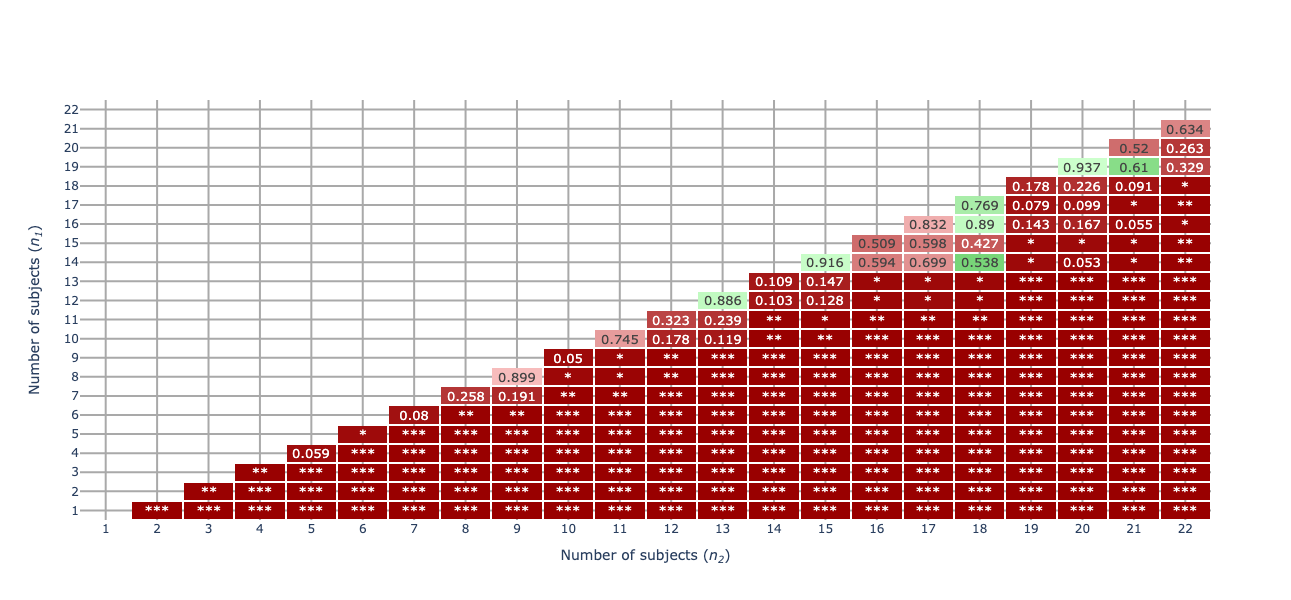

In [29]:
sp_pairwise = plot_pairwise_comparision(reports_sp, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), stars=True, parametric=False, alternative='two-sided')
sp_pairwise

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:382: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/opt/homebrew/Caskroom/miniforge/base/envs/tf310/lib/python3.9/site-packages/pingouin/pairwise.py:383: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



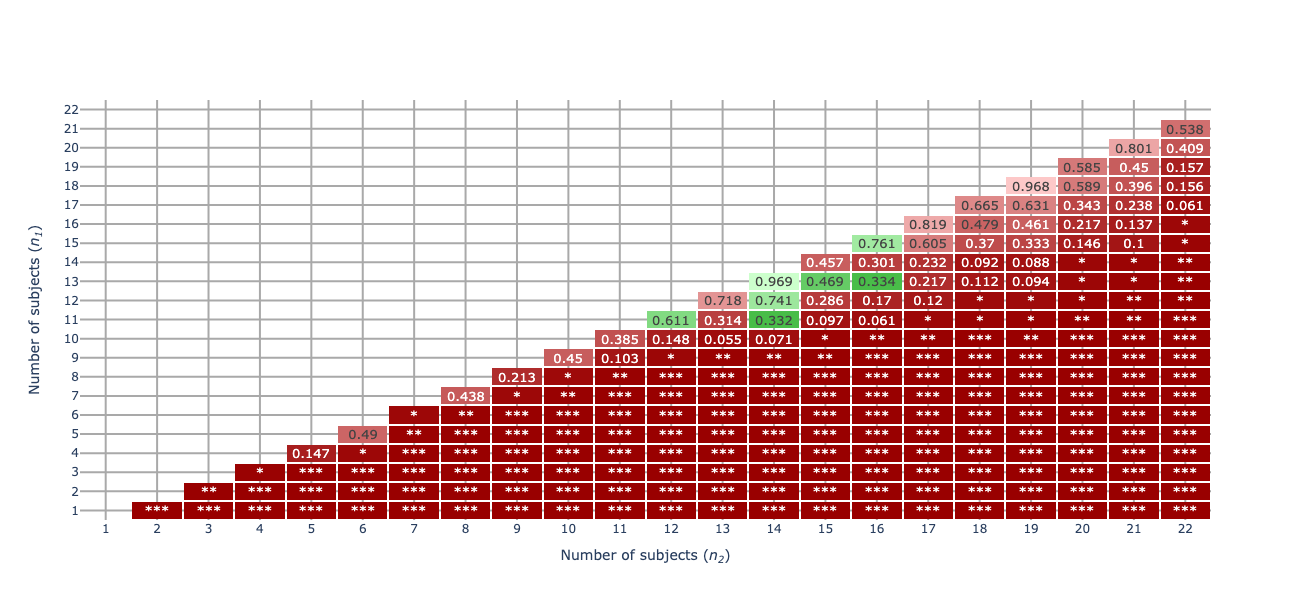

In [30]:
sw_pairwise = plot_pairwise_comparision(reports_sw, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), stars=True, parametric=False, alternative='two-sided')
sw_pairwise

**The above matrixes correspond with the Figure 3 (a and b) of the paper.**

We can observe that:
- The red color indicates that accuracy improvements are achieved. However, not always these improvements are significant.
- When training with low amounts of data (n < 4), just adding one more subject significantly improves the results.
- When training with 4 < n < 10, adding one more subject does not significantly improves de results. More subjects are required.
- With hihger amounts of subjects, several subjects need to be added to obtain significant improvements.

##### Store results

- The tables are stored in `03_RESULTS/03_{sp|sw}-pairwise-table.html`.
- The matrixes are stored in `03_RESULTS/03_{sp|sw}-pairwise-tests.pdf`.

In [31]:
sp_pairwise.write_image(TEST_RESULT.format('03_sp-pairwise'))
sw_pairwise.write_image(TEST_RESULT.format('03_sw-pairwise'))

sp_pairwise_table.to_html(TABLE_RESULT.format('03_sp-pairwise'))
sw_pairwise_table.to_html(TABLE_RESULT.format('03_sw-pairwise'))

### Data sources comparision

Now, we are going to directly compare the performance of the _sp_ and _sw_ models using statistical tests in order to find significant differences.

#### Overall accuracy

In [32]:
overall_comparison = compare_datasources(reports_sp, reports_sw, Filter(TargetFilter.MODEL, ModelMetric.ACCURACY), ['sp', 'sw'], parametric=False)
overall_comparison = overall_comparison.set_index('n')
overall_comparison

median(sp)  median(sw)    U-val  p-val
n                                         
1        0.389       0.670  12662.5  0.000
2        0.657       0.766  16715.0  0.000
3        0.701       0.794  16613.0  0.000
4        0.753       0.812  19020.5  0.000
5        0.772       0.819  20242.0  0.000
6        0.804       0.824  22881.0  0.012
7        0.828       0.833  23801.0  0.063
8        0.831       0.841  24818.5  0.253
9        0.834       0.843  23542.5  0.041
10       0.848       0.849  25969.0  0.736
11       0.849       0.855  25492.5  0.502
12       0.855       0.855  26621.0  0.905
13       0.855       0.859  26597.5  0.918
14       0.866       0.853  29031.0  0.070
15       0.861       0.859  27777.5  0.352
16       0.869       0.857  28909.5  0.085
17       0.869       0.861  28519.5  0.147
18       0.865       0.861  27827.5  0.334
19       0.879       0.862  30525.5  0.004
20       0.877       0.865  29925.5  0.015
21       0.878       0.866  30172.0  0.009
22       0.879       0.867  30470.0  0.005

**This table corresponds with the first three columns from Table 2 of the paper.**

We can observe that:
- Significant difference exist when _n_ < 8, where _sw_ models perform better.
- Significatn difference exist when _n_ > 18, where _sp_ models perform better.


#### Activities F1-score

In [33]:
activities_comparison = compare_activities(reports_sp, reports_sw, ActivityMetric.F1, ['sp', 'sw'])
activities_comparison

activity     SEATED                   STANDING_UP                    \
         median(sp) median(sw)  p-val  median(sp) median(sw)  p-val   
n                                                                     
1             0.000      0.772  0.000       0.116      0.588  0.000   
2             0.397      0.831  0.000       0.407      0.690  0.000   
3             0.561      0.843  0.000       0.454      0.725  0.000   
4             0.706      0.862  0.000       0.564      0.760  0.000   
5             0.757      0.847  0.000       0.618      0.773  0.000   
6             0.784      0.857  0.000       0.695      0.775  0.000   
7             0.798      0.864  0.000       0.704      0.787  0.000   
8             0.824      0.861  0.000       0.737      0.800  0.000   
9             0.805      0.859  0.000       0.742      0.800  0.000   
10            0.820      0.870  0.000       0.747      0.815  0.000   
11            0.818      0.868  0.000       0.754      0.821  0.000   
12            0.831      0.871  0.000       0.758      0.820  0.000   
13            0.836      0.872  0.000       0.764      0.823  0.000   
14            0.836      0.873  0.000       0.786      0.825  0.000   
15            0.839      0.872  0.000       0.777      0.831  0.000   
16            0.838      0.871  0.000       0.789      0.824  0.000   
17            0.835      0.873  0.000       0.794      0.831  0.000   
18            0.845      0.871  0.000       0.790      0.834  0.000   
19            0.845      0.875  0.000       0.806      0.830  0.001   
20            0.843      0.878  0.000       0.808      0.837  0.000   
21            0.849      0.871  0.000       0.808      0.835  0.003   
22            0.854      0.874  0.002       0.816      0.843  0.002   

activity    WALKING                      TURNING                    \
         median(sp) median(sw)  p-val median(sp) median(sw)  p-val   
n                                                                    
1             0.439      0.740  0.000      0.553      0.642  0.000   
2             0.781      0.836  0.000      0.708      0.702  0.677   
3             0.811      0.857  0.000      0.766      0.724  0.023   
4             0.847      0.861  0.057      0.802      0.745  0.000   
5             0.865      0.876  0.275      0.812      0.745  0.000   
6             0.877      0.878  0.870      0.823      0.755  0.000   
7             0.886      0.884  0.564      0.835      0.772  0.000   
8             0.892      0.885  0.126      0.831      0.774  0.000   
9             0.895      0.893  0.565      0.836      0.779  0.000   
10            0.907      0.896  0.002      0.851      0.787  0.000   
11            0.908      0.897  0.010      0.850      0.787  0.000   
12            0.910      0.901  0.005      0.856      0.788  0.000   
13            0.913      0.900  0.002      0.855      0.800  0.000   
14            0.919      0.902  0.000      0.853      0.792  0.000   
15            0.920      0.899  0.000      0.853      0.800  0.000   
16            0.919      0.903  0.000      0.857      0.795  0.000   
17            0.916      0.905  0.000      0.862      0.804  0.000   
18            0.922      0.905  0.000      0.859      0.801  0.000   
19            0.928      0.904  0.000      0.864      0.796  0.000   
20            0.924      0.904  0.000      0.863      0.802  0.000   
21            0.926      0.905  0.000      0.863      0.800  0.000   
22            0.927      0.906  0.000      0.864      0.807  0.000   

activity SITTING_DOWN                    
           median(sp) median(sw)  p-val  
n                                        
1               0.129      0.579  0.000  
2               0.315      0.705  0.000  
3               0.479      0.731  0.000  
4               0.599      0.766  0.000  
5               0.622      0.778  0.000  
6               0.676      0.778  0.000  
7               0.705      0.796  0.000  
8               0.721      0.807  0.000  
9          

**This table corresponds with the columns 4-18 from Table 2 of the paper.**

We can observe that:
- The _sw_ models show a significantly higher performance for the _sitting_, _standing up_ and _sitting down_ activities (non-gait-related).
- The _sp_ models show a significantly higher performance for the _walking_ and _turning_ activities (gait-related). 

#### Store results

- The overall comparison table is stored in `03_RESULTS/04_overall-comparison-table.html`.
- The activities comparison table is stored in `03_RESULTS/04_activities-comparison-table.html`.

In [34]:
overall_comparison.to_html(TABLE_RESULT.format('04_overall-comparison'))
activities_comparison.to_html(TABLE_RESULT.format('04_activities-comparison'))

## Conclusions

- With low amounts of subjects, adding a subject improves the models. However, while training with more subjects, the addition of more subjects is required to obtain significant improvements. 
- _sw_ models perform better with low amounts of subjects (_n_ < 7), while _sp_ models perform better with higher amount of subjects (_n_ > 18)
- Non-gait-related activities were significantly better recognized using the smartwatch data. 
- Gait-related activities were significantly better recognized using the smartphone data.